In [1]:
import xarray as xr
import metpy
from metpy.units import units

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cfgrib

# MIROC 5 Data

In [2]:
# Path to the directory containing the MIROC dataset
first_path = '/data/jtrapp/a/jtrapp/CMIP5/MIROC/'

# End path for the historical 3d variables
end_path_historical = '_Amon_MIROC5_historical_r1i1p1_199001-199912.nc'

# End path for the future 3d variables
end_path_future = '_Amon_MIROC5_rcp85_r1i1p1_209001-209912.nc'

# Historical U-component of the wind
u_past_ds = xr.open_dataset(first_path + 'ua' + end_path_historical).metpy.parse_cf()

# Averages May Values
u_past = u_past_ds['ua'][4::12][:][:].mean('time')

# Future U-component of the wind
u_future_ds = xr.open_dataset(first_path + 'ua' + end_path_future).metpy.parse_cf()

# Average May Values
u_future = u_future_ds['ua'][4::12][:][:].mean('time')

# Change in U-component of the wind
u_delta = u_future-u_past

# Historical V-component of the wind
v_past_ds = xr.open_dataset(first_path + 'va' + end_path_historical).metpy.parse_cf()
v_past = v_past_ds['va'][4::12][:][:].mean('time')

# Future V-component of the wind
v_future_ds = xr.open_dataset(first_path + 'va' + end_path_future).metpy.parse_cf()
v_future = v_future_ds['va'][4::12][:][:].mean('time')

# Change in V-component of the wind
v_delta = v_future-v_past

# Historical Temperature of the air
t_past_ds = xr.open_dataset(first_path + 'ta' + end_path_historical).metpy.parse_cf()
t_past = t_past_ds['ta'][4::12][:][:].mean('time')

# Future Temperature of the air
t_future_ds = xr.open_dataset(first_path + 'ta' + end_path_future).metpy.parse_cf()
t_future = t_future_ds['ta'][4::12][:][:].mean('time')

# Change in Temperature of the air
t_delta = t_future-t_past

# Historical Geopotential height
hght_past_ds = xr.open_dataset(first_path + 'zg' + end_path_historical).metpy.parse_cf()
hght_past = hght_past_ds['zg'][4::12][:][:].mean('time')

# Future Geopotential height
hght_future_ds = xr.open_dataset(first_path + 'zg' + end_path_future).metpy.parse_cf()
hght_future = hght_future_ds['zg'][4::12][:][:].mean('time')

# Change in the Geopotential height
hght_delta = hght_future-hght_past

# Historical Relative humidity
rh_past_ds = xr.open_dataset(first_path + 'hur' + end_path_historical).metpy.parse_cf()
rh_past = rh_past_ds['hur'][4::12][:][:].mean('time')

# Future Relative humidity
rh_future_ds = xr.open_dataset(first_path + 'hur' + end_path_future).metpy.parse_cf()
rh_future = rh_future_ds['hur'][4::12][:][:].mean('time')

# Change in the Relative humidity
rh_delta = rh_future - rh_past

/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [3]:
atmos_vars_ds = xr.merge([u_delta.to_dataset(),
                          v_delta.to_dataset(),
                          t_delta.to_dataset(),
                          hght_delta.to_dataset(),
                          rh_delta.to_dataset()])

# Plot a Cross Section of the Data

### Pre-process the Data

In [4]:
from metpy.interpolate import cross_section

# Use the newly created atmos-3d vars
data = atmos_vars_ds

# Set the start and end points

# 35 degrees North, 120 degrees West
start = (35., -120.)

# 35 degrees North, 90 degrees West
end = (35., -90.)

# Get the cross section and convert lat/lon to supplementary coordinates
cross = cross_section(data, start, end)
cross.set_coords(('lat', 'lon'), True)

# Convert Values

# Ensure pressure levels are in hectopascals (hPa)
cross['plev'].metpy.convert_units('hPa')

# Make sure longitude is in degrees West
cross['lon'] = 360 - cross['lon']

/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  app.launch_new_instance()


### Create the Plot

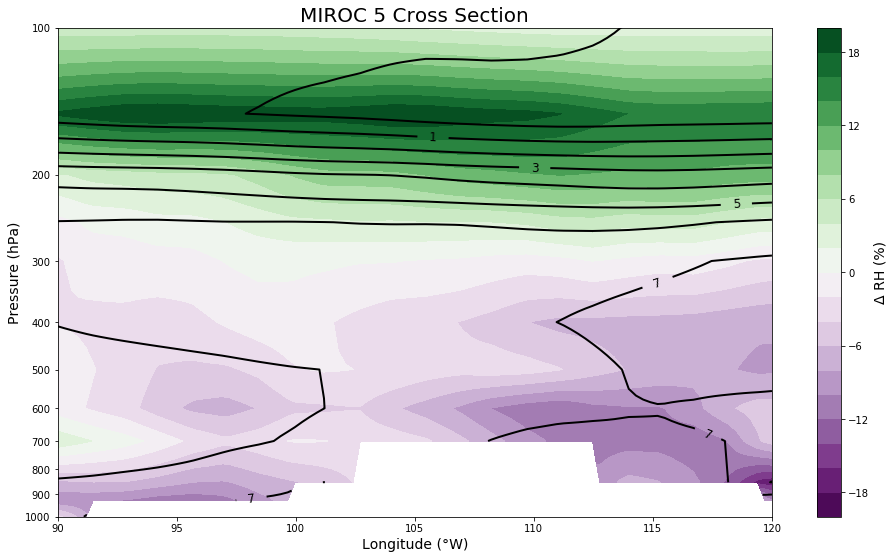

In [5]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['lon'], cross['plev'], cross['hur'],
                         levels=np.arange(-20, 21, 2), cmap='PRGn')
rh_colorbar = fig.colorbar(rh_contour)
rh_colorbar.set_label('\u0394 RH (%)', fontsize=14)

# Plot the temperature using contour, with some custom labeling
temp_contour = ax.contour(cross['lon'], cross['plev'], cross['ta'],
                          levels=np.arange(-12, 12, 1), colors='k', linewidths=2)
temp_contour.clabel(temp_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                    inline_spacing=12, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot the winds using axes interface directly, with some custom indexing to make the barbs less crowded

# Adjust y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(1000, 300)
ax.set_yticks(np.arange(1000, 50, -100))

ax.set_xticks
# Define the CRS and inset axes
ax.set_ylabel('Pressure (hPa)', fontsize=14)
ax.set_xlabel('Longitude ('+u'\N{DEGREE SIGN}'+'W)', fontsize=14)

plt.title('MIROC 5 Cross Section', fontsize=20)
plt.savefig('MIROC5_Cross_Section.png', dpi=100)

## Visualize Upper-Level Data

In [8]:
# Select the levels

# 700 hPa level
low_level = 700 * units.hPa

# 500 hPa level
upper_level = 500 * units.hPa

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(10, 60)

# Grab lat/lon values (GFS will be 1D)
lats = u_ds.lat.sel(lat=lat_slice).values
lons = u_ds.lon.sel(lon=lon_slice).values

# Extract specific levels
tmpk_700 = t_delta.metpy.sel(vertical=low_level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

In [9]:
# Convert temperatures to degree Celsius for plotting purposes
tmpc_700 = (tmpk_700 * units.delta_degC)
#relh_700 = metpy.calc.dewpoint_rh(tmpc_700, rel_h/100.)

In [10]:
# Find the upper level winds
u_upper = u_delta.metpy.sel(vertical=upper_level,lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

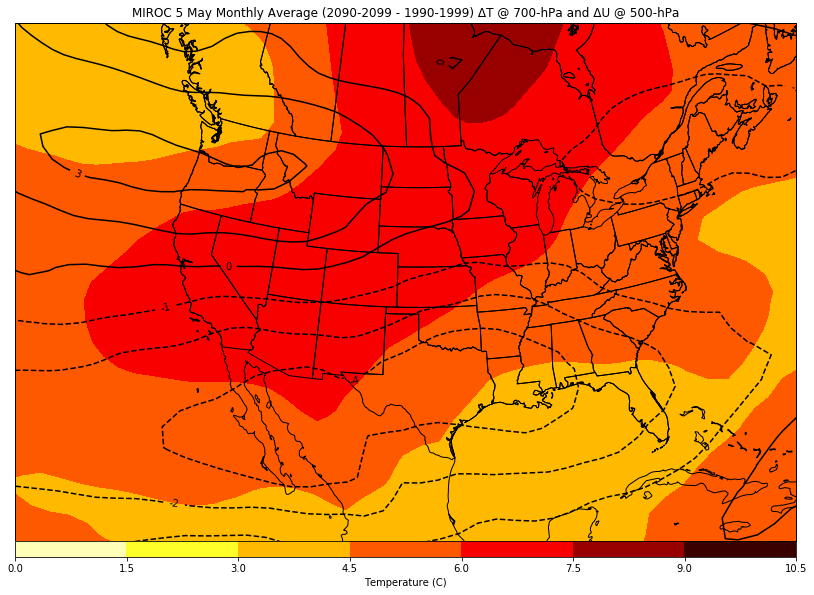

In [11]:
# Set output projection
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set projection of data (so we can transform for the figure)
datacrs = ccrs.PlateCarree()

# Start figure and set extent to be over CONUS
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add coastline and state map features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
clevs_850_tmpc = np.arange(0, 11, 1.5)
cf = ax.contourf(lons, lats, tmpc_700, clevs_850_tmpc, cmap=plt.cm.hot_r, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')
#csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
#                 linestyles='dashed', transform=datacrs)
#plt.clabel(csf, fmt='%d')

# Plot contours of 500-hPa change in zonal wind
clevs_500_delta_u = np.arange(-10, 10, 1.5)
cs = ax.contour(lons, lats, u_upper, clevs_500_delta_u, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')
plt.title('MIROC 5 May Monthly Average (2090-2099 - 1990-1999) \u0394T @ 700-hPa and \u0394U @ 500-hPa')
plt.savefig('MIROC5_DeltaT700_DeltaU500.png')
plt.show()

# GFDL Dataset

In [22]:
# Path to the directory containing the MIROC dataset
first_path = '/data/jtrapp/a/jtrapp/CMIP5/GFDL/'

# End path for the historical 3d variables
end_path_historical1 = '_Amon_GFDL-CM3_historical_r1i1p1_199001-199412.nc'
end_path_historical2 = '_Amon_GFDL-CM3_historical_r1i1p1_199501-199912.nc'

# End path for the future 3d variables
end_path_future1 = '_Amon_GFDL-CM3_rcp85_r1i1p1_209101-209512.nc'
end_path_future2 = '_Amon_GFDL-CM3_rcp85_r1i1p1_209601-210012.nc'

# Historical U-component of the wind
u_past_ds = xr.concat([xr.open_dataset(first_path + 'ua' + end_path_historical1).metpy.parse_cf(),
                      xr.open_dataset(first_path + 'ua' + end_path_historical2).metpy.parse_cf()], dim='time')

# Averages May Values
u_past = u_past_ds['ua'][4::12][:][:].mean('time')

# Future U-component of the wind
u_future_ds = xr.concat([xr.open_dataset(first_path + 'ua' + end_path_future1).metpy.parse_cf(),
                         xr.open_dataset(first_path + 'ua' + end_path_future2).metpy.parse_cf()], dim='time')

# Average May Values
u_future = u_future_ds['ua'][4::12][:][:].mean('time')

# Change in U-component of the wind
u_delta = u_future-u_past

# Historical V-component of the wind
v_past_ds = xr.concat([xr.open_dataset(first_path + 'va' + end_path_historical1).metpy.parse_cf(),
                       xr.open_dataset(first_path + 'va' + end_path_historical2).metpy.parse_cf()], dim='time')

# Average of the past v component of the wind (May)
v_past = v_past_ds['va'][4::12][:][:].mean('time')

# Future V-component of the wind
v_future_ds = xr.concat([xr.open_dataset(first_path + 'va' + end_path_future1).metpy.parse_cf(),
                         xr.open_dataset(first_path + 'va' + end_path_future2).metpy.parse_cf()], dim ='time')

# Average of the future v component of the wind (May)
v_future = v_future_ds['va'][4::12][:][:].mean('time')

# Change in V-component of the wind
v_delta = v_future-v_past

# Historical Temperature of the air
t_past_ds = xr.concat([xr.open_dataset(first_path + 'ta' + end_path_historical1).metpy.parse_cf(),
                       xr.open_dataset(first_path + 'ta' + end_path_historical2).metpy.parse_cf()], dim='time')

t_past = t_past_ds['ta'][4::12][:][:].mean('time')

# Future Temperature of the air
t_future_ds = xr.concat([xr.open_dataset(first_path + 'ta' + end_path_future1).metpy.parse_cf(),
                         xr.open_dataset(first_path + 'ta' + end_path_future2).metpy.parse_cf()], dim='time')

t_future = t_future_ds['ta'][4::12][:][:].mean('time')

# Change in Temperature of the air
t_delta = t_future-t_past

# Historical Geopotential height
hght_past_ds = xr.concat([xr.open_dataset(first_path + 'zg' + end_path_historical1).metpy.parse_cf(),
                          xr.open_dataset(first_path + 'zg' + end_path_historical2).metpy.parse_cf()], dim='time')

hght_past = hght_past_ds['zg'][4::12][:][:].mean('time')

# Future Geopotential height
hght_future_ds = xr.concat([xr.open_dataset(first_path + 'zg' + end_path_future1).metpy.parse_cf(),
                            xr.open_dataset(first_path + 'zg' + end_path_future2).metpy.parse_cf()], dim='time')

hght_future = hght_future_ds['zg'][4::12][:][:].mean('time')

# Change in the Geopotential height
hght_delta = hght_future-hght_past

# Historical Relative humidity
rh_past_ds = xr.concat([xr.open_dataset(first_path + 'hur' + end_path_historical1).metpy.parse_cf(),
                        xr.open_dataset(first_path + 'hur' + end_path_historical2).metpy.parse_cf()], dim='time')

rh_past = rh_past_ds['hur'][4::12][:][:].mean('time')

# Future Relative humidity
rh_future_ds = xr.concat([xr.open_dataset(first_path + 'hur' + end_path_future1).metpy.parse_cf(),
                          xr.open_dataset(first_path + 'hur' + end_path_future2).metpy.parse_cf()], dim='time')

rh_future = rh_future_ds['hur'][4::12][:][:].mean('time')

# Change in the Relative humidity
rh_delta = rh_future - rh_past

/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray

In [23]:
atmos_vars_ds = xr.merge([u_delta.to_dataset(),
                          v_delta.to_dataset(),
                          t_delta.to_dataset(),
                          hght_delta.to_dataset(),
                          rh_delta.to_dataset()])

# Use the newly created atmos-3d vars
data = atmos_vars_ds

# Set the start and end points

# 35 degrees North, 120 degrees West
start = (35., -120.)

# 35 degrees North, 90 degrees West
end = (35., -90.)

# Get the cross section and convert lat/lon to supplementary coordinates
cross = cross_section(data, start, end)
cross.set_coords(('lat', 'lon'), True)

# Convert Values

# Ensure pressure levels are in hectopascals (hPa)
cross['plev'].metpy.convert_units('hPa')

# Make sure longitude is in degrees West
cross['lon'] = 360 - cross['lon']

/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


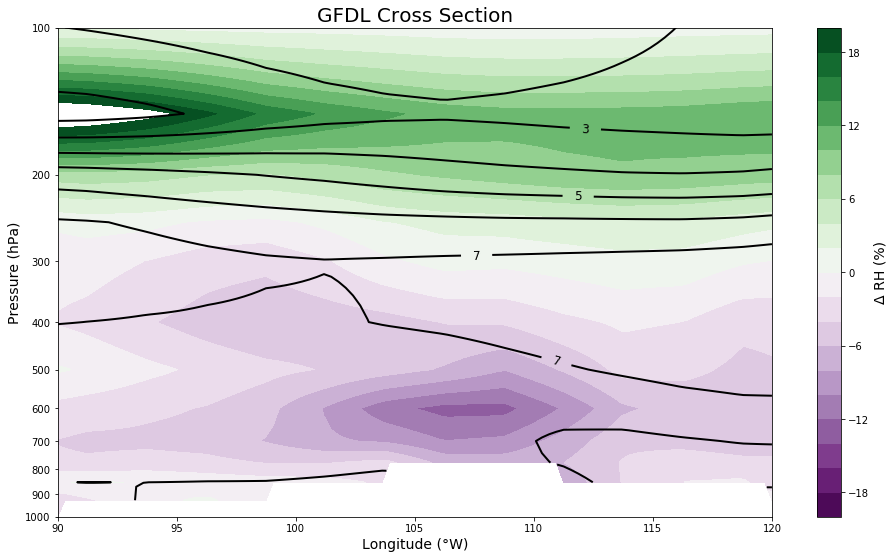

In [24]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['lon'], cross['plev'], cross['hur'],
                         levels=np.arange(-20, 21, 2), cmap='PRGn')
rh_colorbar = fig.colorbar(rh_contour)
rh_colorbar.set_label('\u0394 RH (%)', fontsize=14)

# Plot the temperature using contour, with some custom labeling
temp_contour = ax.contour(cross['lon'], cross['plev'], cross['ta'],
                          levels=np.arange(-12, 12, 1), colors='k', linewidths=2)
temp_contour.clabel(temp_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                    inline_spacing=12, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot the winds using axes interface directly, with some custom indexing to make the barbs less crowded

# Adjust y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(1000, 300)
ax.set_yticks(np.arange(1000, 50, -100))

ax.set_xticks
# Define the CRS and inset axes
ax.set_ylabel('Pressure (hPa)', fontsize=14)
ax.set_xlabel('Longitude ('+u'\N{DEGREE SIGN}'+'W)', fontsize=14)

plt.title('GFDL Cross Section', fontsize=20)
plt.savefig('GFDL_Cross_Section.png', dpi=100)

## Delta T and U 700 hPa Map

In [25]:
# Select the levels
u_ds = u_delta

# 700 hPa level
low_level = 700 * units.hPa

# 500 hPa level
upper_level = 500 * units.hPa

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(10, 60)

# Grab lat/lon values (GFS will be 1D)
lats = u_ds.lat.sel(lat=lat_slice).values
lons = u_ds.lon.sel(lon=lon_slice).values

# Extract specific levels
tmpk_700 = t_delta.metpy.sel(vertical=low_level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

In [26]:
# Find the upper level winds
u_upper = u_delta.metpy.sel(vertical=upper_level,lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

# Convert temperatures to degree Celsius for plotting purposes
tmpc_700 = (tmpk_700 * units.delta_degC)

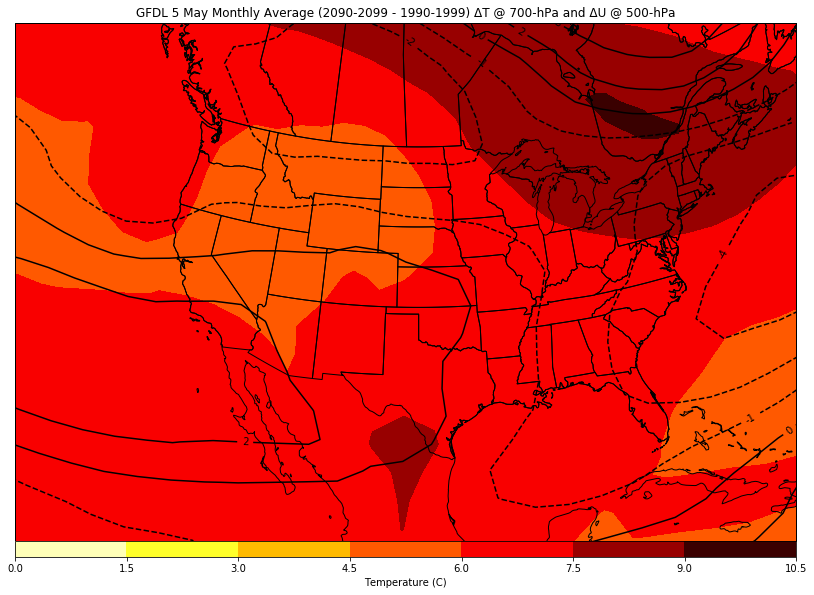

In [27]:
# Set output projection
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set projection of data (so we can transform for the figure)
datacrs = ccrs.PlateCarree()

# Start figure and set extent to be over CONUS
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add coastline and state map features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
clevs_850_tmpc = np.arange(0, 11, 1.5)
cf = ax.contourf(lons, lats, tmpc_700, clevs_850_tmpc, cmap=plt.cm.hot_r, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')
#csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
#                 linestyles='dashed', transform=datacrs)
#plt.clabel(csf, fmt='%d')

# Plot contours of 500-hPa change in zonal wind
clevs_500_delta_u = np.arange(-10, 10, 1.5)
cs = ax.contour(lons, lats, u_upper, clevs_500_delta_u, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')
plt.title('GFDL 5 May Monthly Average (2090-2099 - 1990-1999) \u0394T @ 700-hPa and \u0394U @ 500-hPa')
plt.savefig('GFDL_DeltaT700_DeltaU500.png')
plt.show()

# NCAR CCSM 

In [28]:
# Path to the directory containing the MIROC dataset
first_path = '/data/jtrapp/a/jtrapp/CMIP5/NCAR/'

# End path for the historical 3d variables
end_path_historical = '_Amon_CCSM4_historical_r1i1p1_195001-200512.nc'

# End path for the future 3d variables
end_path_future = '_Amon_CCSM4_rcp85_r1i1p1_208601-210012.nc'

# Historical U-component of the wind
u_past_ds = xr.open_dataset(first_path + 'ua' + end_path_historical).metpy.parse_cf()

# Averages May Values
u_past = u_past_ds['ua'][-188:-72:12].mean('time')

# Future U-component of the wind
u_future_ds = xr.open_dataset(first_path + 'ua' + end_path_future).metpy.parse_cf()

# Average May Values
u_future = u_future_ds['ua'][52:-12:12].mean('time')

# Change in U-component of the wind
u_delta = u_future-u_past

# Historical V-component of the wind
v_past_ds = xr.open_dataset(first_path + 'va' + end_path_historical).metpy.parse_cf()
v_past = v_past_ds['va'][-188:-72:12].mean('time')

# Future V-component of the wind
v_future_ds = xr.open_dataset(first_path + 'va' + end_path_future).metpy.parse_cf()
v_future = v_future_ds['va'][52:-12:12][:][:].mean('time')

# Change in V-component of the wind
v_delta = v_future-v_past

# Historical Temperature of the air
t_past_ds = xr.open_dataset(first_path + 'ta' + end_path_historical).metpy.parse_cf()
t_past = t_past_ds['ta'][-188:-72:12][:][:].mean('time')

# Future Temperature of the air
t_future_ds = xr.open_dataset(first_path + 'ta' + end_path_future).metpy.parse_cf()
t_future = t_future_ds['ta'][52:-12:12][:][:].mean('time')

# Change in Temperature of the air
t_delta = t_future-t_past

# Historical Geopotential height
hght_past_ds = xr.open_dataset(first_path + 'zg' + end_path_historical).metpy.parse_cf()
hght_past = hght_past_ds['zg'][-188:-72:12][:][:].mean('time')

# Future Geopotential height
hght_future_ds = xr.open_dataset(first_path + 'zg' + end_path_future).metpy.parse_cf()
hght_future = hght_future_ds['zg'][52:-12:12][:][:].mean('time')

# Change in the Geopotential height
hght_delta = hght_future-hght_past

# Historical Relative humidity
rh_past_ds = xr.open_dataset(first_path + 'hur' + end_path_historical).metpy.parse_cf()
rh_past = rh_past_ds['hur'][-188:-72:12][:][:].mean('time')

# Future Relative humidity
rh_future_ds = xr.open_dataset(first_path + 'hur' + end_path_future).metpy.parse_cf()
rh_future = rh_future_ds['hur'][52:-12:12][:][:].mean('time')

# Change in the Relative humidity
rh_delta = rh_future - rh_past

/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [53]:
u_ds

<xarray.DataArray 'ua' (plev: 17, lat: 192, lon: 288)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-2.407402, -2.33353 , ..., -2.547656, -2.479034],
        [-2.284688, -2.213613, ..., -2.423543, -2.354676]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-0.665683, -0.599444, ..., -0.797192, -0.731641],
        [-0.579168, -0.514969, ..., -0.706707, -0.64309 ]],

       ...,

       [[ 4.262982,  4.299883, ...,  4.183111,  4.224052],
        [ 4.19696 ,  4.228519, ...,  4.127577,  4.163342],
        ...,
        [-2.263797, -2.21733 , ..., -2.352711, -2.30893 ],
        [-2.15708 , -2.108024, ..., -2.25209 , -2.20511 ]],

       [[ 5.841932,  5.880129, ...,  5.757215,  5.800953],
        [ 5.790934,  5.82243 , ...,  5.719486,  5.756637],
        ...,
        [-2.18202 , -2.14937 , ..., -2.243191, -

In [30]:
atmos_vars_ds = xr.merge([u_delta.to_dataset(),
                          v_delta.to_dataset(),
                          t_delta.to_dataset(),
                          hght_delta.to_dataset(),
                          rh_delta.to_dataset()])

# Use the newly created atmos-3d vars
data = atmos_vars_ds

# Set the start and end points

# 35 degrees North, 120 degrees West
start = (35., -120.)

# 35 degrees North, 90 degrees West
end = (35., -90.)

# Get the cross section and convert lat/lon to supplementary coordinates
cross = cross_section(data, start, end)
cross.set_coords(('lat', 'lon'), True)

# Convert Values

# Ensure pressure levels are in hectopascals (hPa)
cross['plev'].metpy.convert_units('hPa')

# Make sure longitude is in degrees West
cross['lon'] = 360 - cross['lon']

/data/keeling/a/mgrover4/anaconda3/envs/devel/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


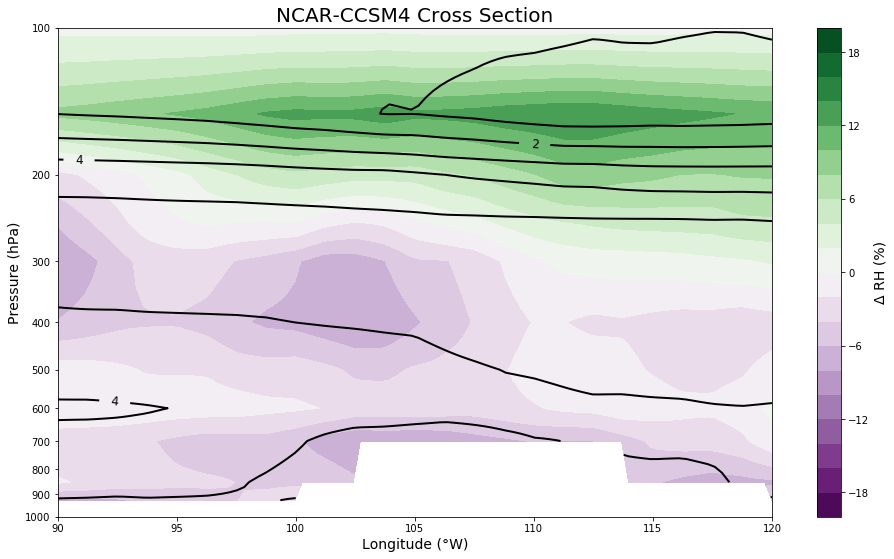

In [42]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['lon'], cross['plev'], cross['hur'],
                         levels=np.arange(-20, 21, 2), cmap='PRGn')
rh_colorbar = fig.colorbar(rh_contour)
rh_colorbar.set_label('\u0394 RH (%)', fontsize=14)

# Plot the temperature using contour, with some custom labeling
temp_contour = ax.contour(cross['lon'], cross['plev'], cross['ta'],
                          levels=np.arange(-12, 12, 1), colors='k', linewidths=2)
temp_contour.clabel(temp_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                    inline_spacing=12, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot the winds using axes interface directly, with some custom indexing to make the barbs less crowded

# Adjust y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(1000, 200)
ax.set_yticks(np.arange(1000, 50, -100))

ax.set_xticks
# Define the CRS and inset axes
ax.set_ylabel('Pressure (hPa)', fontsize=14)
ax.set_xlabel('Longitude ('+u'\N{DEGREE SIGN}'+'W)', fontsize=14)

plt.title('NCAR-CCSM4 Cross Section', fontsize=20)
plt.savefig('NCAR_Cross_Section.png', dpi=100)

In [32]:
# Select the levels
u_ds = u_delta

# 700 hPa level
low_level = 700 * units.hPa

# 500 hPa level
upper_level = 500 * units.hPa

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(10, 60)

# Grab lat/lon values (GFS will be 1D)
lats = u_ds.lat.sel(lat=lat_slice).values
lons = u_ds.lon.sel(lon=lon_slice).values

# Extract specific levels
tmpk_700 = t_delta.metpy.sel(vertical=low_level, lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

In [33]:
# Find the upper level winds
u_upper = u_delta.metpy.sel(vertical=upper_level,lat=lat_slice, lon=lon_slice).squeeze().metpy.unit_array

# Convert temperatures to degree Celsius for plotting purposes
tmpc_700 = (tmpk_700 * units.delta_degC)

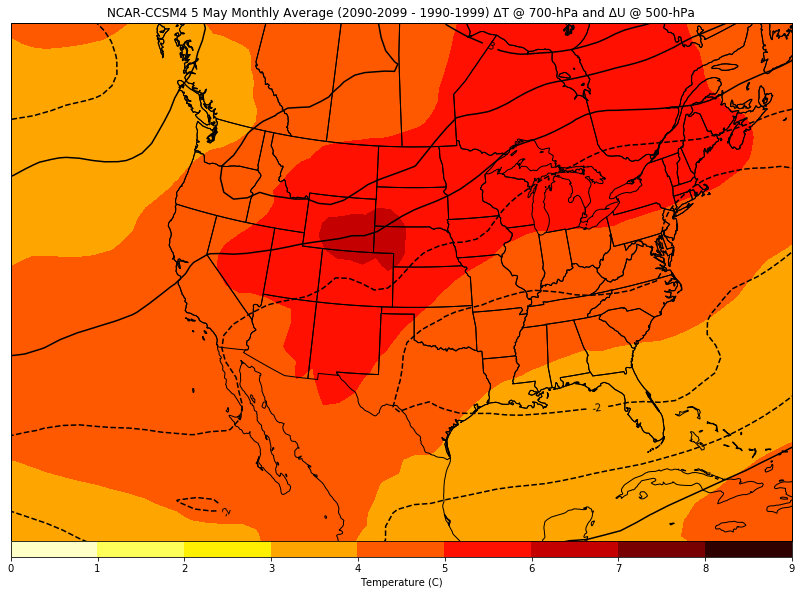

In [34]:
# Set output projection
mapcrs = ccrs.LambertConformal(
    central_longitude=-100, central_latitude=35, standard_parallels=(30, 60))

# Set projection of data (so we can transform for the figure)
datacrs = ccrs.PlateCarree()

# Start figure and set extent to be over CONUS
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add coastline and state map features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
clevs_850_tmpc = np.arange(0, 10, 1)
cf = ax.contourf(lons, lats, tmpc_700, clevs_850_tmpc, cmap=plt.cm.hot_r, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')
#csf = ax.contour(lons, lats, tmpc_850, clevs_850_tmpc, colors='grey',
#                 linestyles='dashed', transform=datacrs)
#plt.clabel(csf, fmt='%d')

# Plot contours of 500-hPa change in zonal wind
clevs_500_delta_u = np.arange(-10, 10, 1.5)
cs = ax.contour(lons, lats, u_upper, clevs_500_delta_u, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')
plt.title('NCAR-CCSM4 5 May Monthly Average (2090-2099 - 1990-1999) \u0394T @ 700-hPa and \u0394U @ 500-hPa')
plt.savefig('NCAR_DeltaT700_DeltaU500.png')
plt.show()